In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python.retinotopy import utils as retutils

from pipeline.python import utils as putils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf


from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

In [2]:
%matplotlib notebook

In [3]:
def filter_retino_cells(magratios, pass_criterion='all', mag_thr=0.01):
    conds = [c for c in magratios.columns if c!='blank']
    if pass_criterion=='all':
        soma_rois = [i for i in magratios.index \
                        if all(magratios[conds].loc[i] >= mag_thr)]
    elif pass_criterion=='mean':
        meanrs = magratios[conds].mean(axis=1)
        soma_rois = meanrs[meanrs>mag_thr].index.tolist()
        
    elif pass_criterion=='either':
        az_conds = [c for c in magratios.columns if c in ['right', 'left']]
        el_conds = [c for c in magratios.columns if c in ['top', 'bottom']]
        soma_rois = [i for i in magratios.index \
                    if (any(magratios[az_conds].loc[i] >= mag_thr) \
                        and (any(magratios[el_conds].loc[i] >= mag_thr))) ]

    elif pass_criterion == 'any':
        soma_rois = [i for i in magratios.index \
                        if any(magratios[conds].loc[i] >= mag_thr) ]
    return soma_rois

In [4]:
def smooth_timecourse(in_trace):
    #smooth trace
    conv_win_size = 41

    trace_pad = np.pad(in_trace, ((conv_win_size/2, conv_win_size/2)), 'edge')

    smooth_trace = np.convolve(trace_pad,np.ones((conv_win_size,))*(1/float(conv_win_size)),'valid')
    
    return smooth_trace

In [5]:
def fft_to_absolute(phases_soma, screen_min=-62, screen_max=62):
    # Get absolute coords
    phases_w = retutils.correct_phase_wrap(phases_soma) # wraps from 0 to 2pi

    absolute_az = (phases_w['left'] - phases_w['right']) / 2.  # cont (-pi, pi)
    absolute_el = (phases_w['bottom'] - phases_w['top']) / 2.

    # Convert to degrees
    vmin, vmax = -np.pi, np.pi
    lin_az = retutils.convert_range(absolute_az, oldmin=-np.pi, oldmax=np.pi, 
                                    newmin=screen_min, newmax=screen_max)
    lin_el = retutils.convert_range(absolute_el, oldmin=vmin, oldmax=vmax,
                                    newmin=screen_min, newmax=screen_max)

    rpos = pd.DataFrame({'az': lin_az, 'el': lin_el}).astype(float)
    
    return rpos

In [6]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [7]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### RF params
responsive_test = None
responsive_thr = None
n_stds = None
response_type = 'dff'

#### Filter RF datasets by
do_spherical_correction=False
rf_filter_by=None
rf_fit_thr=0.5
rf_type = 'sphr' if do_spherical_correction else ''
rf_fit_desc = fitrf.get_fit_desc(response_type=response_type, do_spherical_correction=do_spherical_correction)
rf_str = '%s_%s' % (rf_filter_by, rf_type)
print(rf_str)
print(rf_fit_desc)

#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.002
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr
retino_str = '%s-thr%.3f' % (pass_criterion, mag_thr)
print(retino_str)


None_
fit-2dgaus_dff-no-cutoff
pixels-thr0.002


In [8]:
# Set data identifiers
fig_id = '%s|%s|%s -- ret: %s| rf: %s, filter %s' % (fov_type, state, traceid, retino_str, rf_fit_desc, rf_str)
print(fig_id)


zoom2p0x|awake|traces001 -- ret: pixels-thr0.002| rf: fit-2dgaus_dff-no-cutoff, filter None_


# Output dir

In [9]:
basedir = os.path.join(aggr_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc), 'compare_retino')

if not os.path.exists(basedir):
    os.makedirs(basedir)
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/compare_retino'

# Metadata

In [10]:
sdata = aggr.get_aggregate_info(traceid=traceid)
rdata = sdata[sdata['experiment'].isin(['retino', 'rfs', 'rfs10'])]
edata = aggr.include_dsets_with(rdata, experiment='retino', also_include='rfs')
both_datakeys = edata['datakey'].unique()
print(len(both_datakeys))

Segmentation: missing 9 dsets
45


In [11]:
print(rdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(edata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

             datakey
visual_area         
Li                26
Ll                 4
Lm                24
V1                19
             datakey
visual_area         
Li                16
Ll                 2
Lm                17
V1                19


In [12]:
missing_rfs = sdata[(sdata['experiment']=='retino') & ~(sdata['datakey'].isin(both_datakeys))]['datakey'].unique()
print("Missing RFs for %i datasets:" % len(missing_rfs))
for m in sorted(missing_rfs):
    print m

Missing RFs for 14 datasets:
20190306_JC061_fov2
20190306_JC061_fov3
20190314_JC070_fov1
20190314_JC070_fov2
20190315_JC070_fov1
20190315_JC070_fov2
20190315_JC070_fov3
20190316_JC070_fov1
20190319_JC067_fov1
20190320_JC067_fov1
20190321_JC070_fov1
20190322_JC073_fov1
20190327_JC073_fov1
20190422_JC076_fov1


In [13]:
edata[edata['visual_area']=='V1']['datakey'].unique()

array(['20190420_JC076_fov1', '20190501_JC076_fov1',
       '20190504_JC078_fov1', '20190509_JC078_fov1',
       '20190507_JC083_fov1', '20190508_JC083_fov1',
       '20190510_JC083_fov1', '20190511_JC083_fov1',
       '20190512_JC083_fov1', '20190517_JC083_fov1',
       '20190522_JC084_fov1', '20190622_JC085_fov1',
       '20190613_JC097_fov1', '20190615_JC097_fov2',
       '20190616_JC097_fov1', '20190617_JC097_fov1',
       '20191004_JC110_fov2', '20191006_JC110_fov1',
       '20191111_JC117_fov1'], dtype=object)

# Load RF fits

In [14]:
from pipeline.python.retinotopy import segment_retinotopy as seg

In [15]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/rf_utils.pyc'>

In [16]:
#### Load RF fits
print("Loading RF fits (%s)" % rf_fit_desc)
rfdf = rfutils.load_rfdf_with_positions(rf_fit_desc, traceid=traceid, create_new=False,
                                        filter_by=None, reliable_only=True)

#### Average rf/rf10 together to get maximal cells
assigned_cells, missing_seg = seg.get_cells_by_area(sdata, return_missing=True)
rfdf_avg = aggr.get_rfdata(assigned_cells, rfdf, average_repeats=True)

Loading RF fits (fit-2dgaus_dff-no-cutoff)
Segmentation: missing 9 dsets
[filter_by=None] Excluding 1 total repeats
Selecting 80 dsets
N dpaths: 53, N unfit: 0
N datasets included: 63, N sessions excluded: 4
Segmentation: missing 0 dsets
Calculating RF coord conversions...
... saved: /n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl
Segmentation: missing 3 dsets


In [17]:
# rftest = aggr.load_rfdf_and_pos(rf_dsets1)


In [17]:
#### Screen dims and info
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

screen_top = screen['altitude_deg']/2.
screen_right = screen['azimuth_deg']/2.
elev_cutoff = screen_top / screen_right
print(elev_cutoff)

pp.pprint(screen)

0.563106617463
{   'altitude_cm': 58.0,
    'altitude_deg': 67.323,
    'azimuth_cm': 103.0,
    'azimuth_deg': 119.5564,
    'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
    'resolution': [1920, 1080]}


# 1 FOV

In [18]:
# datakey = '20190602_JC091_fov1'
# visual_area='Li'

#datakey = '20190522_JC084_fov1' 
#datakey = '20190617_JC097_fov1'
datakey = '20190327_JC073_fov1'

visual_area='Li'
session, animalid, fovnum = putils.split_datakey_str(datakey)
fov='FOV%i_zoom2p0x' % fovnum


# Get retino runs
found_retinoruns = [os.path.split(d)[-1] for d in 
                    glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))]
print("Found %i runs" % len(found_retinoruns))
retinorun = found_retinoruns[-1]
print(retinorun)

scaninfo = retutils.get_protocol_info(animalid, session, fov, run=retinorun)
stiminfo = scaninfo['stimulus']
pp.pprint(stiminfo.keys())


#### Get RF info for this FOV      
currdf = rfdf_avg[(rfdf_avg['visual_area']==visual_area) 
                & (rfdf_avg['datakey']==datakey)].copy()
curr_rois = currdf['cell'].unique()
incl_rois = None
print("%i cells with RFs" % len(curr_rois))

Found 3 runs
retino_run3
[   'n_cycles',
    'frame_rate',
    'n_reps',
    'stim_freq',
    'n_frames_per_cycle',
    'cycle_start_ixs',
    'freqs',
    'stim_freq_idx',
    'n_frames']
0 cells with RFs


In [21]:
#### Get FFT results
fft_results = retutils.load_fft_results(animalid, session, fov, retinorun=retinorun, 
                        traceid=traceid, create_new=True, 
                        trace_type='raw', detrend_after_average=True, in_negative=False)
magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_results['fft_soma']) 
magratios_np, phases_np = retutils.extract_from_fft_results(fft_results['fft_neuropil']) 


rpos = fft_to_absolute(phases_soma)
rpos_np = fft_to_absolute(phases_np)

... loading paradigm info
Found 12 tifs
Temporal ds: 5.00
... loading traces (neuropil)
... loading traces (raw)


0 cells pass thr.


<IPython.core.display.Javascript object>


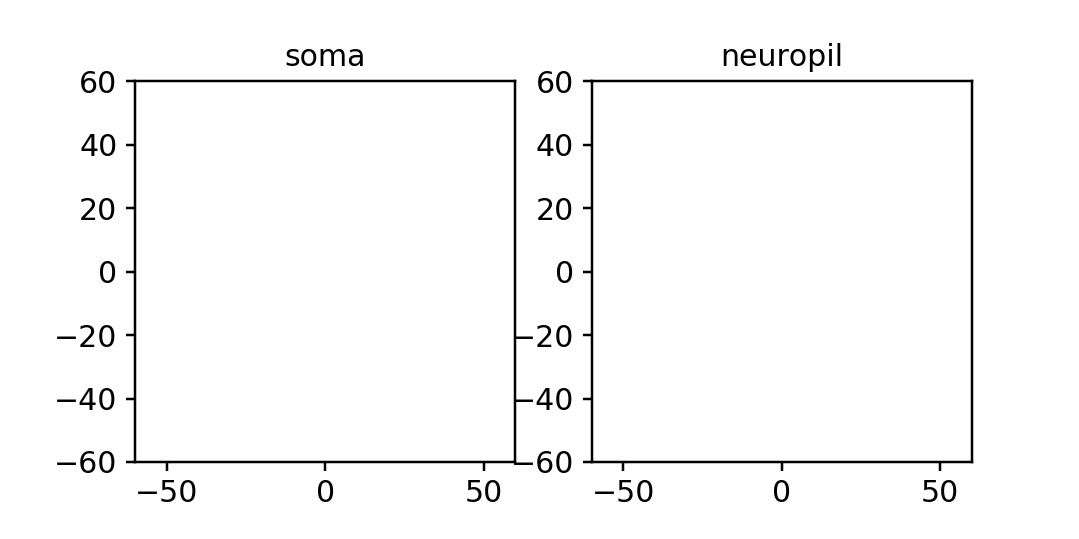

Text(0.5,1,u'neuropil')

In [20]:
pass_soma = filter_retino_cells(magratios_soma, pass_criterion='all', mag_thr=0.01)
print("%i cells pass thr." % len(pass_soma))
soma_colors = sns.color_palette('rainbow', n_colors=len(pass_soma))

fig, axn = pl.subplots(1,2, figsize=(6,3))

ax=axn[0]
ax.scatter(rpos['az'][pass_soma], rpos_np['az'][pass_soma], c=soma_colors)
ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])
ax.set_aspect('equal')
ax.set_title("soma")

ax=axn[1]
ax.scatter(rpos['el'][pass_soma], rpos_np['el'][pass_soma], c=soma_colors)
ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])
ax.set_aspect('equal')
ax.set_title("neuropil")

In [523]:
# #### Get FFT results
# fft_results2 = retutils.load_fft_results(animalid, session, fov, retinorun=retinorun, 
#                         traceid=traceid, create_new=True, 
#                         trace_type='raw', detrend_after_average=True, in_negative=True)
# magratios_soma2, phases_soma2 = retutils.extract_from_fft_results(fft_results2['fft_soma']) 
# # return -pi, pi

# phases_soma2=phases_soma2*-1.0
# lin_az2 = phase_to_screen_loc(phases_soma2['right'],phases_soma2['left'])
# lin_el2 = phase_to_screen_loc(phases_soma2['bottom'],phases_soma2['top'])


# rpos_invert = pd.DataFrame({'az_inv': lin_az2, 'el_inv': lin_el2}).astype(float)


... loading paradigm info
Found 12 tifs
Temporal ds: 5.00
... loading traces (neuropil)
... loading traces (raw)


In [667]:
# def wrapdiff(diff, deg=False):
#     #from circtstats toolbox
    
#     """Given an array of angle differences, make sure that they lie
#     between -pi and pi.
#     Parameters
#     ----------
#     diff : np.ndarray
#         The angle difference array
#     deg : bool (default=False)
#         Whether the angles are in degrees or radians
#     Returns
#     -------
#     out : np.ndarray
#         The updated angle differences
#     """

#     if deg:
#         base = 360
#     else:
#         base = np.pi * 2

#     i = np.abs(diff) > (base / 2.0)
#     out = diff.copy()
#     out[i] -= np.sign(diff[i]) * base
#     return out

In [26]:
soma_traces = retutils.load_traces(animalid, session, fov, run=retinorun,
                    analysisid='traces001', trace_type='raw', detrend_after_average=True, )

np_traces = retutils.load_traces(animalid, session, fov, run=retinorun,
                    analysisid='traces001', trace_type='neuropil', detrend_after_average=True)

... loading traces (raw)
Specified ID <traces001> not eligible. Selecting 1st of [u'analysis002']
... loading traces (neuropil)
Specified ID <traces001> not eligible. Selecting 1st of [u'analysis002']


In [27]:
in_negative=False
# Do fft
n_frames = scaninfo['stimulus']['n_frames']
frame_rate = scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']

#### label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate))
sorted_freq_idxs = np.argsort(freqs)

smoothed_traces={}
for k, v in soma_traces.items():
    smoothed_traces[k] = v.apply(smooth_timecourse)

smoothed_np={}
for k, v in np_traces.items():
    smoothed_np[k] = v.apply(smooth_timecourse)


In [28]:
sign = -1 if in_negative else 1
fft_soma = dict((cond, retutils.do_fft_analysis(sign*tdf, sorted_freq_idxs, stim_freq_idx)) \
                for cond, tdf in smoothed_traces.items())

magratios_sm, phases_sm = retutils.extract_from_fft_results(fft_soma) 


In [29]:
# def phase_to_screen_loc(combo_phase0,combo_phase1, screen_deg=119.5564): #117.5584):

#     #THE MAGIC PART

#     # I am assuming this means that label indicates where stimulus bar started
#     twice_delay = combo_phase0+combo_phase1
#     phase_diff =combo_phase0-combo_phase1
#     inf_phase = np.true_divide(phase_diff,2)+np.pi

#     #translate phase to degree of visual angle-for intuition
#     real_loc = (screen_deg*(inf_phase))/(2*np.pi)
    
#     return real_loc - screen_max

In [30]:
# Get absolute coords
rpos = fft_to_absolute(phases_soma)
rpos_sm = fft_to_absolute(phases_sm)
# phases_w = retutils.correct_phase_wrap(phases_soma) # wraps from 0 to 2pi
# phases_w_sm = retutils.correct_phase_wrap(phases_sm) # wraps from 0 to 2pi

# absolute_az = (phases_w['left'] - phases_w['right']) / 2.  # cont (-pi, pi)
# absolute_el = (phases_w['bottom'] - phases_w['top']) / 2.

# absolute_az_sm = (phases_w_sm['left'] - phases_w_sm['right']) / 2.  # cont (-pi, pi)
# absolute_el_sm = (phases_w_sm['bottom'] - phases_w_sm['top']) / 2.


# Convert to degrees
# vmin, vmax = -np.pi, np.pi
# lin_az = retutils.convert_range(absolute_az, oldmin=-np.pi, oldmax=np.pi, newmin=screen_min, newmax=screen_max)
# lin_el = retutils.convert_range(absolute_el, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)

# lin_az_sm = retutils.convert_range(absolute_az_sm, oldmin=-np.pi, oldmax=np.pi, newmin=screen_min, newmax=screen_max)
# lin_el_sm = retutils.convert_range(absolute_el_sm, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)

# retino_pos = pd.DataFrame({'az': lin_az, 'el': lin_el,
#                            'az2': lin_az2, 'el2': lin_el2,
#                            'az_sm': lin_az_sm, 'el_sm': lin_el_sm}).astype(float)
# del retino_pos
rpos_sm = rpos_sm.rename(columns={'az': 'az_sm', 'el': 'el_sm'})
retinodf = pd.concat([rpos, rpos_sm ], axis=1)
#retinodf = retinodf.copy() #.loc[curr_rois]
print(retinodf['az'].min(), retinodf['az'].max())

retinodf.head()

(-55.94832483255101, 54.16531098656566)


,az,el,az_sm,el_sm
0,34.639236,-1.259960,34.638030,-1.243179
1,30.491407,-4.227534,30.389045,-4.196620
2,35.819212,4.205776,35.834487,4.057946
3,37.524256,0.224308,37.670017,0.193992
4,34.511656,-3.080301,34.482397,-3.084814


In [31]:
elev_cutoff

0.5631066174625532

In [32]:
def draw_screen(ax=None, pos_max=62, screen_max=59.7782, elev_cut_off=0.5631):
    
    # RETINO.
    ax.set_xlim([-pos_max, pos_max])
    ax.set_ylim([-pos_max, pos_max])
    
    vmin, vmax = -screen_max, screen_max
    ax.axhline(y=vmin*elev_cutoff)
    ax.axhline(y=vmax*elev_cutoff)
    
    ax.axvline(x=-screen_max)
    ax.axvline(x=screen_max)
    
    ax.set_aspect('equal')



28 cells | 107 pass retino | 100 w RFs


<IPython.core.display.Javascript object>


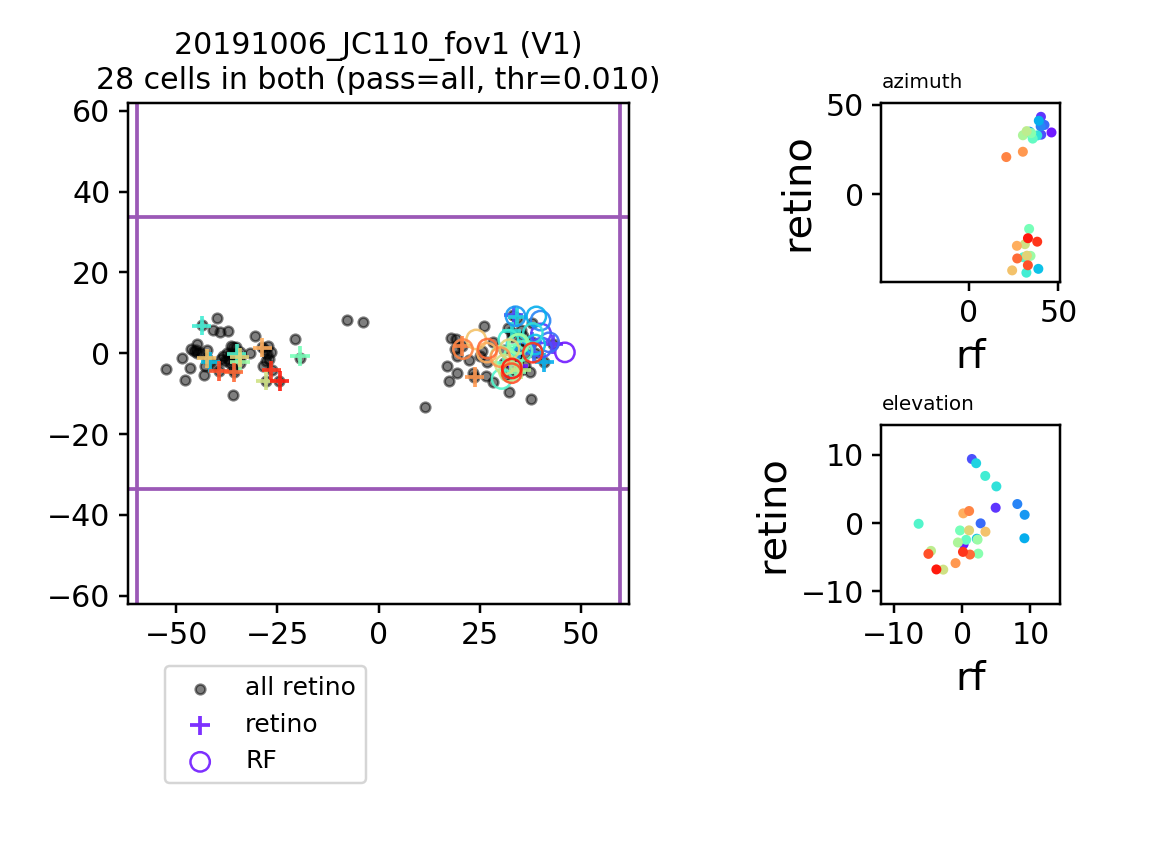

In [33]:
mag_thr=0.01
pass_criterion='all'

pass_rois = filter_retino_cells(magratios_soma, 
                                pass_criterion=pass_criterion, mag_thr=mag_thr)
incl_rois = np.intersect1d(pass_rois, curr_rois)
print("%i cells | %i pass retino | %i w RFs" % (len(incl_rois), len(pass_rois), len(curr_rois)))


fig = pl.figure()
gs = gridspec.GridSpec(2,3) #fig.add_gridspec(2,2)

# RETINO.
ax=fig.add_subplot(gs[0:2, 0:-1])
draw_screen(ax)

# RETINO:  plot all
ax.scatter(retinodf['az'][pass_rois], retinodf['el'][pass_rois], \
           c='k', marker='.', alpha=0.5, s=60, label='all retino')

# RETINO:  plot well-fit
# ax.scatter(retinodf.loc[incl_rois]['az_inv'], retinodf.loc[incl_rois]['el_inv'], \
#            c='c', marker='o', alpha=0.5, label='reversed')

roi_colors = sns.color_palette('rainbow', n_colors=len(incl_rois))

# RETINO:  plot well-fit
ax.scatter(retinodf.loc[incl_rois]['az_sm'], retinodf.loc[incl_rois]['el_sm'], \
           marker='+', alpha=0.9, edgecolor=roi_colors, facecolor=roi_colors, 
           s=60, label='retino')

# RFS:  plot positions
rf_x = currdf[currdf['cell'].isin(incl_rois)]['x0'].copy()
rf_y = currdf[currdf['cell'].isin(incl_rois)]['y0'].copy()
ax.scatter(rf_x, rf_y,  marker='o', edgecolor=roi_colors, facecolor='none',
           s=60, alpha=0.9, label='RF')

ax.legend(bbox_to_anchor=(0.5, -0.1))

ax.set_title('%s (%s)\n%i cells in both (pass=%s, thr=%.3f)' \
             % (datakey, visual_area, len(incl_rois), pass_criterion, mag_thr))
# compare ----------------
retino_x = retinodf.loc[incl_rois]['az']
retino_y = retinodf.loc[incl_rois]['el']

# X-POSITION 
ax=fig.add_subplot(gs[0, -1])
min_x = min([rf_x.min(), retino_x.min()])
max_x = max([rf_x.max(), retino_x.max()])
ax.set_title('azimuth', fontsize=8, loc='left')

ax.scatter(rf_x, retino_x, c=roi_colors, marker='.')
ax.set_ylim([min_x-5, max_x+5])
ax.set_xlim([min_x-5, max_x+5])
ax.set_aspect('equal')

ax.set_xlabel('rf')
ax.set_ylabel('retino')

# Y-POSITION
ax=fig.add_subplot(gs[1, -1])
min_y = min([rf_y.min(), retino_y.min()])
max_y = max([rf_y.max(), retino_y.max()])
ax.set_title('elevation', fontsize=8, loc='left')

ax.scatter(rf_y, retino_y, c=roi_colors, marker='.')
ax.set_ylim([min_y-5, max_y+5])
ax.set_xlim([min_y-5, max_y+5])
ax.set_aspect('equal')
ax.set_xlabel('rf')
ax.set_ylabel('retino')

pl.subplots_adjust(wspace=0.6, right=0.95, left=0.05, bottom=0.3, hspace=0.8)



In [467]:
currdf.head()

,animalid,datakey,session,fov_xpos,fov_ypos,ml_pos,ap_pos,cell,r2,fwhm_x,...,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,fov_xpos_pix,fov_ypos_pix,visual_area,experiment
1919,JC097,20190617_JC097_fov1,20190617,163.62,78.0524,894.748,1013.98,2,0.549391,22.000012,...,27.134636,9.361707,6.871347,0.153413,0.473589,-0.013475,71,41,V1,average_rfs
1920,JC097,20190617_JC097_fov1,20190617,168.229,49.4967,923.303,1009.37,4,0.639729,20.769255,...,9.080363,8.837981,5.428203,0.239011,0.158482,-0.163570,73,26,V1,average_rfs
1921,JC097,20190617_JC097_fov1,20190617,92.18,236.061,736.739,1085.42,21,0.664993,17.132004,...,166.797407,9.615801,7.290214,0.137560,-0.230429,-0.074724,40,124,V1,average_rfs
1922,JC097,20190617_JC097_fov1,20190617,48.3945,306.499,666.301,1129.21,24,0.572205,33.803426,...,16.230184,14.384437,9.579940,0.200485,0.283270,-0.088415,21,161,V1,average_rfs
1923,JC097,20190617_JC097_fov1,20190617,69.135,336.958,635.842,1108.46,25,0.658212,26.306403,...,359.210265,11.194214,7.762285,0.181042,-0.013783,-0.176052,30,177,V1,average_rfs


<IPython.core.display.Javascript object>


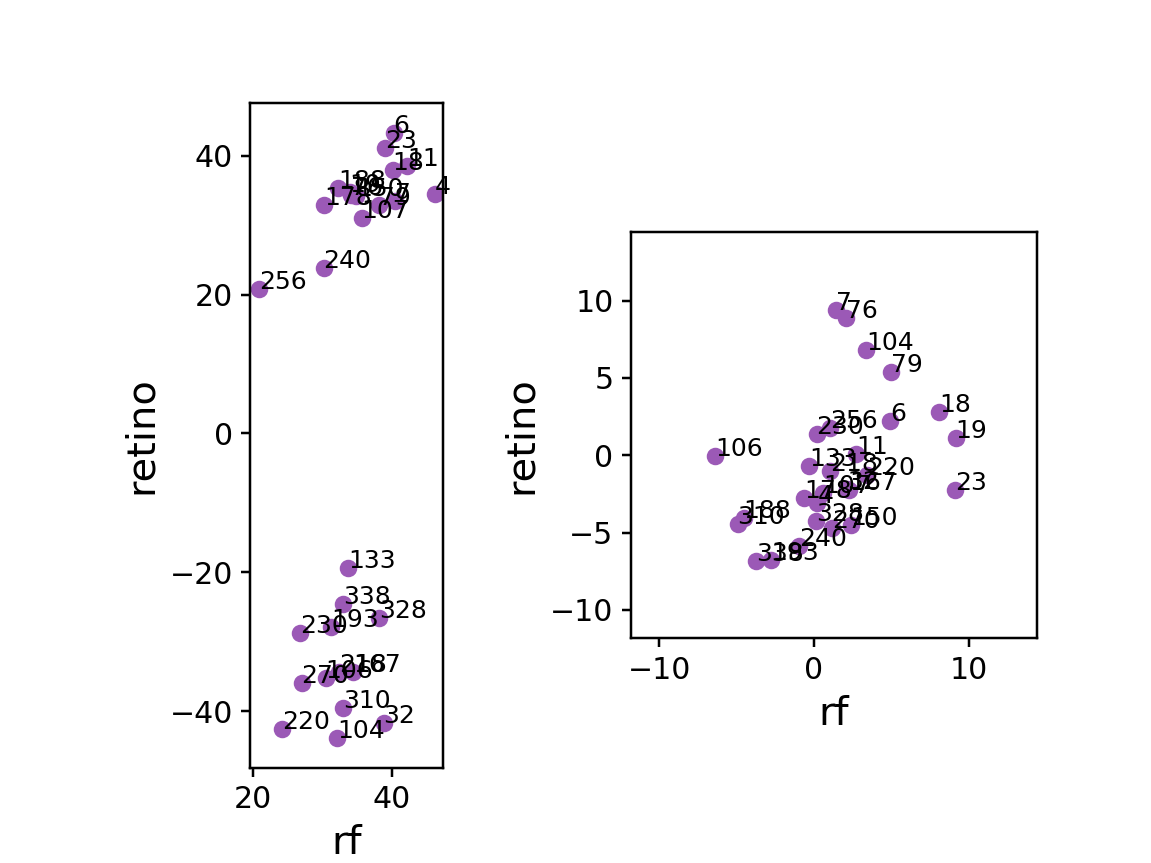

Text(0.5,0,u'rf')

In [34]:
currdf = currdf.rename(index=dict((i, v) for i, v in zip(currdf.index.tolist(), currdf['cell'].values)))


fig, axn = pl.subplots(1, 2)
ax=axn[0]
axis = 'x'
x = currdf.loc[incl_rois]['x0'] if axis=='x' else currdf.loc[incl_rois]['y0']
y = retinodf.loc[incl_rois]['az_sm'] if axis=='x' else retinodf.loc[incl_rois]['el_sm']
ax.scatter(x.values, y.values)
ax.set_aspect('equal')

for i in incl_rois:
    ax.text(x.loc[i], y.loc[i], i)
ax.set_ylabel('retino')
ax.set_xlabel('rf')


ax=axn[1]
axis = 'y'
x = currdf.loc[incl_rois]['x0'] if axis=='x' else currdf.loc[incl_rois]['y0']
y = retinodf.loc[incl_rois]['az_sm'] if axis=='x' else retinodf.loc[incl_rois]['el_sm']
ax.scatter(x.values, y.values)
ymin=min([x.min(), y.min()])
ymax = max([x.max(), y.max()])
ax.set_aspect('equal')
ax.set_ylim([ymin-5, ymax+5])
ax.set_xlim([ymin-5, ymax+5])

for i in incl_rois:
    ax.text(x.loc[i], y.loc[i], i)
ax.set_ylabel('retino')
ax.set_xlabel('rf')




In [624]:
#20190522_JC084_fov1: currdf[currdf['cell'].isin([178, 236, 237])][['cell', 'x0', 'y0', 'std_x', 'std_y', 'r2']]

funky = retinodf[(retinodf['el_sm']>(screen_max*elev_cutoff))].loc[incl_rois]
#funky = retinodf.loc[pass_rois][(retinodf['az_sm']<0)].loc[incl_rois]


funky_rois=funky.dropna().index.tolist()
print(funky_rois)
funky.head()

# currdf[currdf['cell'].isin(funky)][['cell', 'x0', 'y0', 'std_x', 'std_y', 'r2']]

[236]


,az,el,az_sm,el_sm,az_inv,el_inv
11,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN


In [625]:
retino_ = retinodf.loc[pass_rois].copy()
rf_ = currdf[currdf['cell'].isin(pass_rois)][['cell', 'x0', 'y0', 'std_x', 'std_y', 'r2']].copy()
rf_ = rf_.rename(index=dict((i, r) for i, r in zip(rf_.index.tolist(), rf_['cell'])))
combined_df = pd.concat([retino_, rf_], axis=1)
print(combined_df.shape)
combined_df.head()

(18, 12)


,az,el,az_sm,el_sm,az_inv,el_inv,cell,x0,y0,std_x,std_y,r2
11,14.866423,-14.024057,14.854885,-14.087155,-14.333677,-13.521498,11.0,21.731005,-11.021150,10.846261,7.772666,0.840521
14,18.126843,-12.174994,18.076112,-12.173765,-17.477258,-11.738698,14.0,19.750647,-13.680022,8.909238,7.112431,0.538714
17,14.381699,-8.128826,14.380420,-8.067259,-13.866323,-7.837525,17.0,23.642326,-15.119404,10.098291,13.816368,0.848801
48,18.913349,-14.807013,18.902033,-14.816266,-18.235580,-14.276396,NaN,NaN,NaN,NaN,NaN,NaN
57,20.925576,-10.548249,20.988039,-10.599820,-20.175698,-10.170247,57.0,21.908378,-18.680668,10.555132,7.472871,0.869147


In [626]:
datakey

'20190522_JC084_fov1'

In [627]:
if 'blank' in magratios_soma.keys():
    fig, ax = pl.subplots()

    for cond in retino_conds:
        ax.hist(magratios_soma[cond], cumulative=True, histtype='step', label=cond)

    pl.legend()
    print(magratios_soma['blank'].max())

In [629]:
colors=dict((k,c) for k, c in zip(['right', 'left', 'top', 'bottom'], ['r','b', 'm','c']))

# conditions = ['left', 'right', 'bottom', 'top']

# fig, axn = pl.subplots(len(funky_rois)+1, 4, sharex=True, sharey=True, 
#                        figsize=(7,len(funky_rois)*2))
# retino_conds = soma_traces.keys()

# for ai, rid in enumerate(funky_rois):
#     for cond in retino_conds:
#         ac = conditions.index(cond)
#         ax=axn[ai, ac]
        
#         ax.set_title("%s" % (cond), loc='center')
#         ax.plot(soma_traces[cond][rid], label=cond, color='k', lw=0.5)
        
#         ax.plot(smoothed_traces[cond][rid], label=cond, color=colors[cond], lw=1)
#     axn[ai, 0].set_ylabel(rid, rotation=90)
# fig.suptitle(datakey)



In [630]:
colors

{'bottom': 'c', 'left': 'b', 'right': 'r', 'top': 'm'}

In [640]:
half_cyc=float(np.unique(np.diff(stiminfo['cycle_start_ixs'])/2.))

In [653]:
plot_rois = copy.copy(funky_rois)
extra_rois = [i for i in pass_rois if i not in plot_rois] #[57, 67, 14]
plot_rois.extend(extra_rois)

# fig, axn = pl.subplots(len(plot_rois), 2, figsize=(7,len(plot_rois)*3.))

# for ar, rid in enumerate(plot_rois):
    

fig, axn = pl.subplots(len(plot_rois), 2, sharex=True, sharey=False, figsize=(9,len(plot_rois)*2))
retino_conds = soma_traces.keys()

for ai, rid in enumerate(plot_rois):
    for cond in retino_conds:
        if cond in ['left', 'right']:
            ac=0
        else:
            ac=1
        #ac = conditions.index(cond)
        ax=axn[ai, ac]
        ax.set_title("%s" % (cond), loc='center')
        #ax.plot(soma_traces[cond][rid], label=cond, color='k', lw=0.5)
        
        ax.plot(smoothed_traces[cond][rid], #-smoothed_traces[cond][rid].mean(), 
                label=cond, color=colors[cond], lw=1)
        for c in stiminfo['cycle_start_ixs']:
            ax.axvline(x=c, linestyle='-', color='k', lw=1)
            ax.axvline(x=c+half_cyc, linestyle=':', color='k', lw=1)
        
    axn[ai, 0].set_ylabel(rid, rotation=90)
fig.suptitle(datakey)
pl.subplots_adjust(hspace=0.6, top=0.8, left=0.08, right=0.99)

<IPython.core.display.Javascript object>

In [656]:
len(incl_rois), len(pass_rois), len(curr_rois)

(61, 94, 130)

In [657]:
130-94

36

In [659]:
rfs_no_retino = [i for i in curr_rois if i not in pass_rois]
retino_no_rfs = [i for i in pass_rois if i not in curr_rois]
len(rfs_no_retino), len(retino_no_rfs)
#retinodf.loc[rfs_no_retino]

(69, 33)

In [605]:
combined_df.dropna()

,az,el,az_sm,el_sm,az_inv,el_inv,cell,x0,y0,std_x,std_y,r2
11,14.866423,-14.024057,14.854885,-14.087155,-14.333677,-13.521498,11.0,21.731005,-11.021150,10.846261,7.772666,0.840521
14,18.126843,-12.174994,18.076112,-12.173765,-17.477258,-11.738698,14.0,19.750647,-13.680022,8.909238,7.112431,0.538714
17,14.381699,-8.128826,14.380420,-8.067259,-13.866323,-7.837525,17.0,23.642326,-15.119404,10.098291,13.816368,0.848801
57,20.925576,-10.548249,20.988039,-10.599820,-20.175698,-10.170247,57.0,21.908378,-18.680668,10.555132,7.472871,0.869147
63,20.246789,-21.904711,20.359736,-21.796376,-19.521236,-21.119746,63.0,20.367754,-21.463229,9.028116,7.025509,0.711258
67,16.044842,-16.474302,16.017989,-16.436723,-15.469867,-15.883937,67.0,19.436665,-21.040144,3.952811,5.677656,0.672989
68,18.827081,-18.565696,18.776324,-18.556172,-18.152403,-17.900385,68.0,20.320030,-23.033776,6.881694,10.019351,0.910561
75,12.642582,-22.300838,12.628847,-22.260343,-12.189529,-21.501676,75.0,16.659624,-22.695124,11.423798,5.455151,0.813761
106,22.157445,-10.650341,22.110039,-10.593999,-21.363422,-10.268681,106.0,20.608717,-12.047235,10.137500,7.943657,0.846820
116,14.578655,-15.137263,14.529268,-15.064135,-14.056222,-14.594812,116.0,17.180319,-14.569971,10.328877,8.633183,0.843791


In [632]:
from scipy.signal import find_peaks


In [636]:
stimfreq = scaninfo['stimulus']['stim_freq']

frametimes = np.array(scaninfo['frame_tstamps_sec'])

stimperiod_t=np.true_divide(1,stimfreq)
stimperiod_frames=stimperiod_t*frame_rate
periodstartframes=np.round(np.arange(0,len(frametimes),stimperiod_frames))[:]
periodstartframes = periodstartframes.astype('int')

periodstartframes_expand = np.hstack((periodstartframes,len(frametimes)))

periodhalfframes = np.floor(np.convolve(periodstartframes_expand,np.array([0.5,0.5]),'valid')).astype('int')
periodstartframes

array([   0,  186,  372,  558,  744,  930, 1116, 1302, 1488, 1674, 1861,
       2047, 2233])

<IPython.core.display.Javascript object>


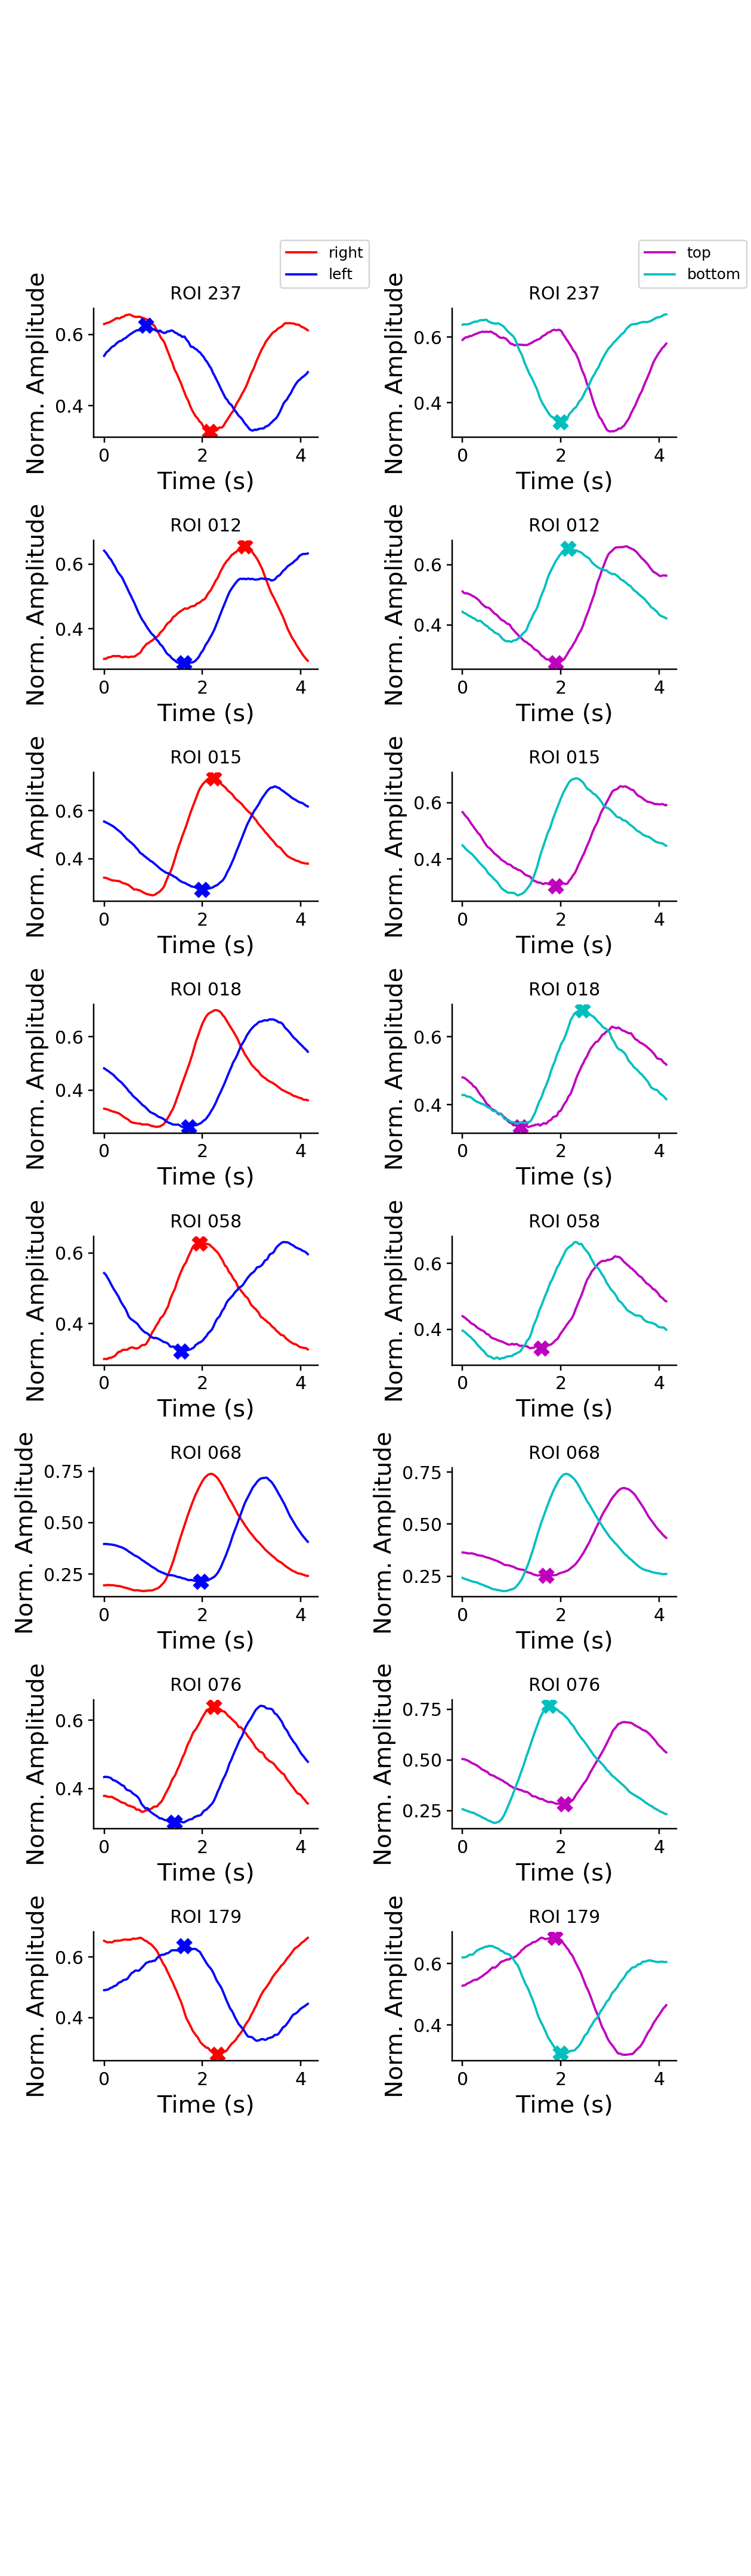

------ top ------
236
FAILED!!!
------ right ------
trough first
------ bottom ------
trough first
------ left ------
peak first
------ top ------
trough first
------ right ------
peak first
------ bottom ------
peak first
------ left ------
trough first
------ top ------
trough first
------ right ------
peak first
------ bottom ------
14
FAILED!!!
------ left ------
trough first
------ top ------
trough first
------ right ------
17
FAILED!!!
------ bottom ------
peak first
------ left ------
trough first
------ top ------
trough first
------ right ------
peak first
------ bottom ------
57
FAILED!!!
------ left ------
trough first
------ top ------
trough first
------ right ------
67
FAILED!!!
------ bottom ------
67
FAILED!!!
------ left ------
trough first
------ top ------
trough first
------ right ------
peak first
------ bottom ------
peak first
------ left ------
trough first
------ top ------
peak first
------ right ------
trough first
------ bottom ------
trough first
------ le

In [637]:
plot_rois = copy.copy(funky_rois)
plot_rois.extend(extra_rois)

fig, axn = pl.subplots(len(plot_rois), 2, figsize=(7,len(plot_rois)*3.))

for ar, rid in enumerate(plot_rois):

    for cond in soma_traces.keys():

        if cond in ['left', 'right']:
            ai=0
        else:
            ai=1

        ax=axn[ar, ai]

        print("------ %s ------" % cond)

        right_trace0 = soma_traces[cond][rid].copy().values
        period_frames = np.diff(periodstartframes)[0]

        for idx,f in enumerate(periodstartframes[0:-1]):

            period_trace = right_trace0[f:f+period_frames]
            period_trace = period_trace-period_trace[0]

          #  period_trace = smooth_timecourse(period_trace)
            period_trace_norm = (period_trace - np.min(period_trace))/(np.max(period_trace)-np.min(period_trace))
            period_trace_norm = smooth_timecourse(period_trace_norm)
            if idx == 0:
                period_sum = period_trace_norm
            else:
                if period_sum.size > period_trace_norm.size:
                    period_sum = period_sum[0:period_trace_norm.size]
                period_sum = period_sum + period_trace_norm

        period_sum = period_sum/(idx+1)

        #2) FIND PEAKS AND/OR TROUGHS IN THE AVERAGED TRACE
        feature_width = 60 #hard-coding
        x = period_sum
        peaks, _ = find_peaks(x,distance = period_frames,width = feature_width)
        troughs, _ = find_peaks(-x,distance = period_frames,width = feature_width)

        # plot
        ax.plot(frametimes[0:x.size],x, label=cond, color=colors[cond])
        ax.plot(frametimes[peaks], x[peaks], "X", color=colors[cond], markersize=10)
        ax.plot(frametimes[troughs], x[troughs], "X", color=colors[cond], markersize=10)
        sns.despine(fig=fig, ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Norm. Amplitude')

        ax.set_title('ROI %03d' % int(rid+1))

        if len(peaks)==0 and len(troughs)==0:
            print(rid)
            print('FAILED!!!') # FAILED TO FIND PEAKS OR VALLEYS!
        elif len(peaks)>0 and len(troughs)>0:
            if peaks[0]<troughs[0]:
                print('peak first')

            else:
                print('trough first')

        else:
            if len(peaks)>0 and len(troughs)==0:
                print('peak first')

            if len(peaks)==0 and len(troughs)>0:
                print('trough first')
        
        if ar==0:
            ax.legend(bbox_to_anchor=(0.8, 1.1))
pl.subplots_adjust(wspace=0.6, hspace=0.8, bottom=0.2)


<IPython.core.display.Javascript object>


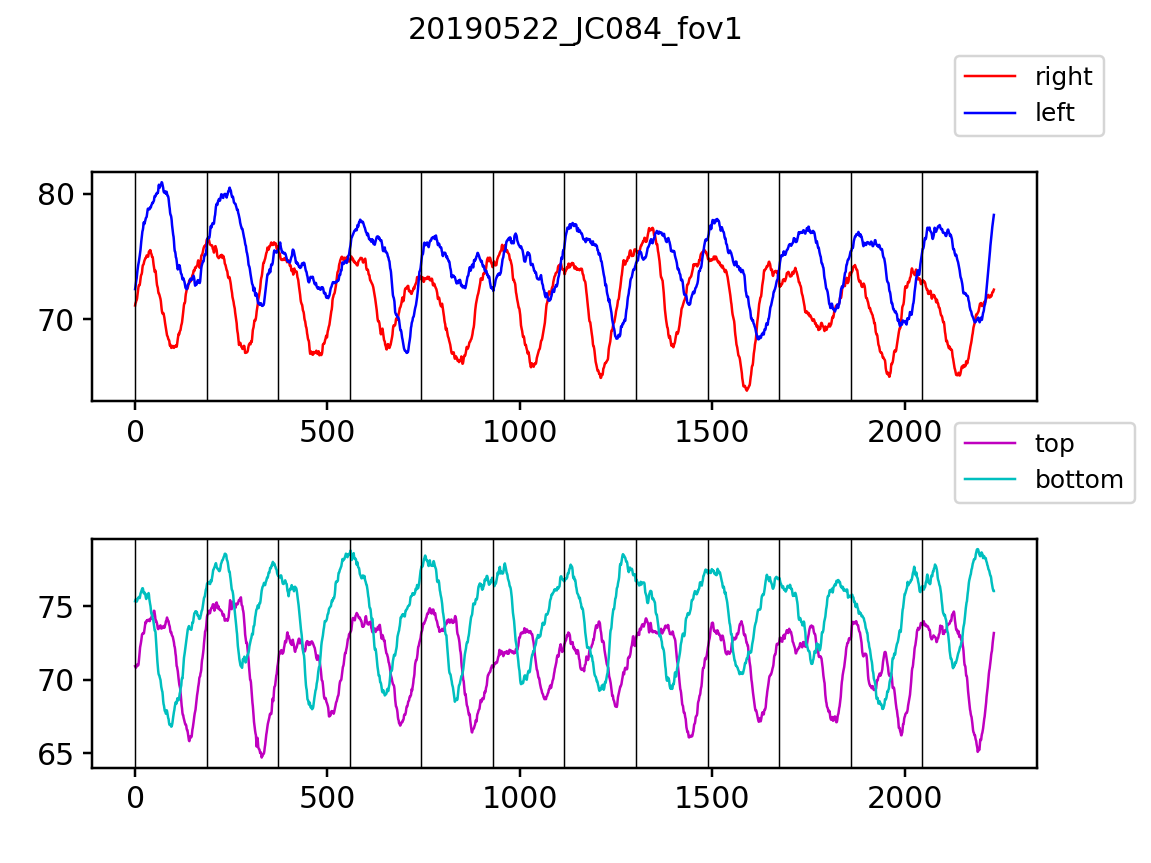

In [558]:
rid=236
fig, axn= pl.subplots(2,1)

for cond in retino_conds:
    if cond in ['left', 'right']:
        ac=0
    else:
        ac=1
    #ac = conditions.index(cond)
    ax=axn[ac]
    #ax.set_title("%s" % (cond), loc='center')
    #ax.plot(soma_traces[cond][rid], label=cond, color='k', lw=0.5)

    ax.plot(smoothed_traces[cond][rid], #-smoothed_traces[cond][rid].mean(), 
            label=cond, color=colors[cond], lw=1)
    for c in stiminfo['cycle_start_ixs']:
        ax.axvline(x=c, linestyle='-', color='k', lw=0.5)
    ax.legend(bbox_to_anchor=(0.9, 1.1))
    
fig.suptitle(datakey)
pl.subplots_adjust(hspace=0.6, top=0.8, left=0.08, right=0.9)

<IPython.core.display.Javascript object>


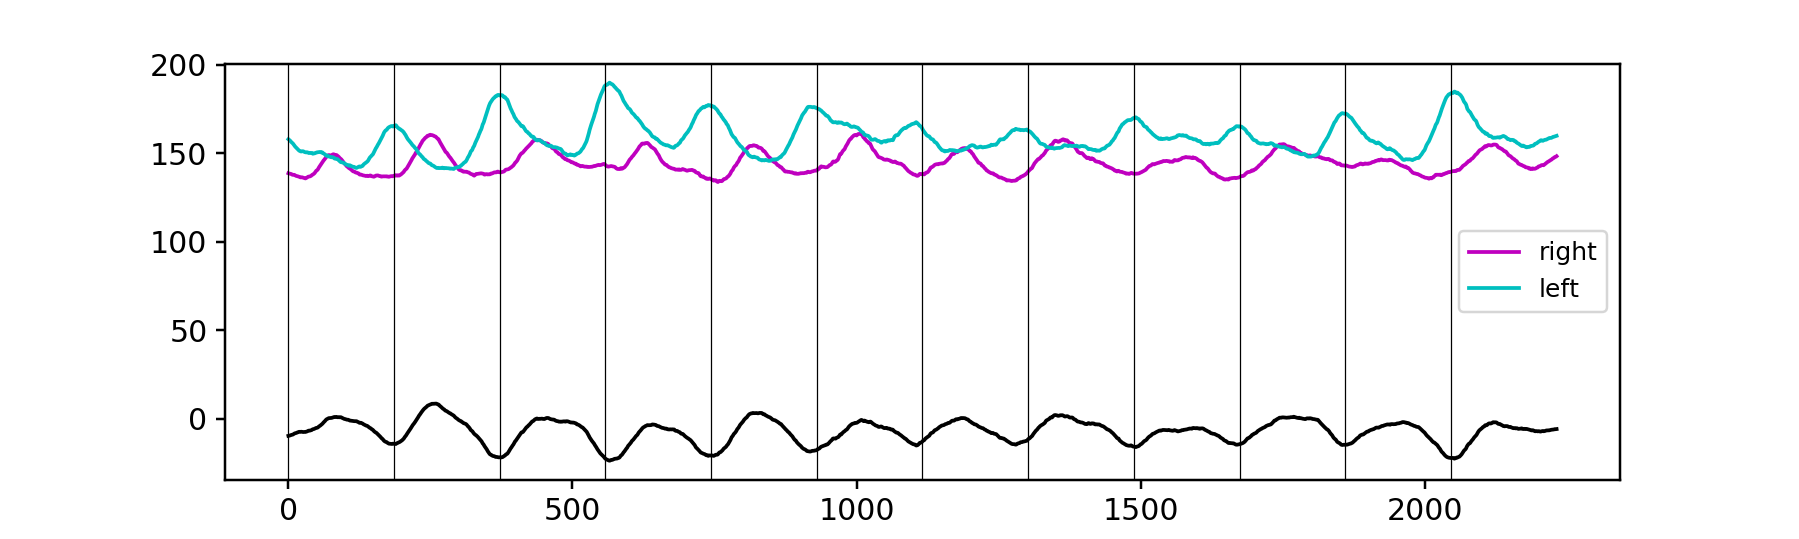

In [494]:
vals = (smoothed_traces['right'][rid].values - smoothed_traces['left'][rid].values)/2.
fig, ax = pl.subplots(figsize=(10,3))
# ax.plot(smoothed_traces['right'][rid] - smoothed_traces['right'][rid].mean(), 'm', label='right')
# ax.plot(smoothed_traces['left'][rid] - smoothed_traces['left'][rid].mean(), 'c', label='left')
ax.plot(smoothed_traces['right'][rid] , 'm', label='right')
ax.plot(smoothed_traces['left'][rid], 'c', label='left')


ax.plot(vals, 'k')
for c in stiminfo['cycle_start_ixs']:
    ax.axvline(x=c, linestyle='-', color='k', lw=0.5)

ax.legend()

In [1000]:
(phases_soma['left'][rid]-phases_soma['right'][rid])/2.

-0.6724022422457141

# Test CaImAn

In [263]:
trace_fn = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/average_traces.pkl'
with open(trace_fn, 'rb') as f:
    cmn_results = pkl.load(f)
    
caiman_traces = cmn_results['traces']
caiman_rois = cmn_results['rois']

In [265]:
caiman = dict((k, pd.DataFrame(t, columns=caiman_rois)) for k, t in caiman_traces.items())


In [266]:
fft_caiman = dict((cond, retutils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) \
                        for cond, tdf in caiman.items())

In [267]:
magratios_cm, phases_cm = retutils.extract_from_fft_results(fft_caiman) # return -pi, pi

In [268]:
# Get absolute coords
phases_w_cm = retutils.correct_phase_wrap(phases_cm) # wraps from 0 to 2pi
# phases_w2 = retutils.make_continuous(phases_soma)
absolute_az_cm = (phases_w_cm['left'] - phases_w_cm['right']) / 2.  # cont (-pi, pi)
absolute_el_cm = (phases_w_cm['bottom'] - phases_w_cm['top']) / 2.

# delay_az = retutils.correct_phase_wrap( (phases_w['left'] + phases_w['right']) / 2. )
# delay_el = retutils.correct_phase_wrap( (phases_w['bottom'] + phases_w['top']) / 2. )
print(absolute_az_cm.min(), absolute_az_cm.max())

# Convert to degrees
vmin, vmax = -np.pi, np.pi
lin_az_cm = retutils.convert_range(absolute_az_cm, oldmin=-np.pi, oldmax=np.pi, newmin=screen_min, newmax=screen_max)
lin_el_cm = retutils.convert_range(absolute_el_cm, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)
retino_cm = pd.DataFrame({'az': lin_az_cm, 'el': lin_el_cm}).astype(float)

retinodf_cm = retino_cm.copy() #.loc[curr_rois]
retinodf_cm['az'].min(), retinodf_cm['az'].max()

(-2.89395610524568, 3.06223009063191)


(-55.06617372972308, 58.26808978390055)

34 of 42 cells pass (130 cells in area)


<IPython.core.display.Javascript object>


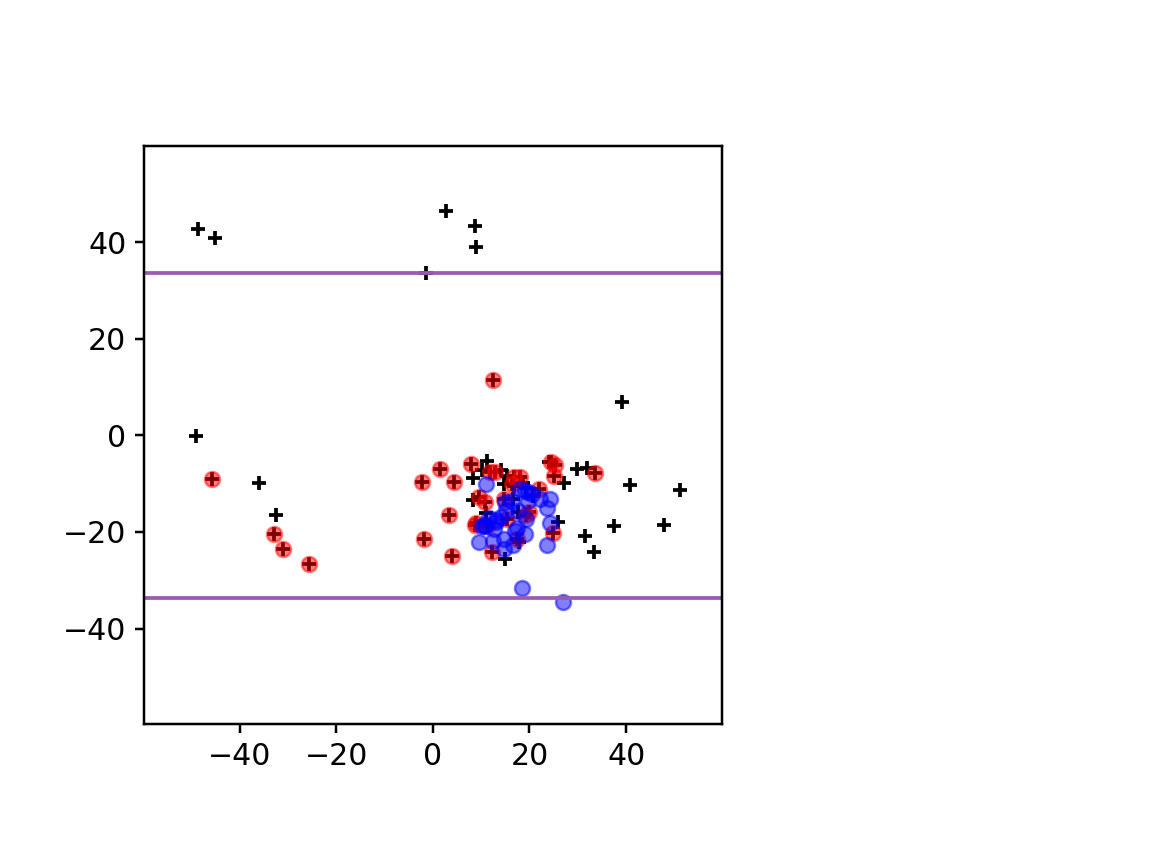

In [274]:
pass_rois2 = filter_retino_cells(magratios_cm, pass_criterion='all', mag_thr=0.02)
incl_rois2 = np.intersect1d(pass_rois2, curr_rois)
print("%i of %i cells pass (%i cells in area)" \
      % (len(incl_rois2), len(pass_rois), len(curr_rois)))

fig = pl.figure()
gs = gridspec.GridSpec(2,3) #fig.add_gridspec(2,2)

# RETINO.
ax=fig.add_subplot(gs[0:2, 0:-1])
ax.set_xlim([-screen_max, screen_max])
ax.set_ylim([-screen_max, screen_max])
vmin, vmax = screen_min, screen_max
ax.axhline(y=vmin*elev_cutoff)
ax.axhline(y=vmax*elev_cutoff)
ax.set_aspect('equal')

# RETINO:  plot all
ax.scatter(retinodf_cm['az'][pass_rois2], retinodf_cm['el'][pass_rois2], \
           c='k', marker='+', label='all')

# RETINO:  plot well-fit
ax.scatter(retinodf_cm.loc[incl_rois2]['az'], retinodf_cm.loc[incl_rois2]['el'], \
           c='r', marker='o', alpha=0.5)

# RFS:  plot positions
# ax.scatter(currdf['x0'], currdf['y0'])
rf_x = currdf[currdf['cell'].isin(incl_rois2)]['x0'].copy()
rf_y = currdf[currdf['cell'].isin(incl_rois2)]['y0'].copy()
ax.scatter(rf_x, rf_y, c='b', alpha=0.5)



In [1031]:
incl_rois2

[26, 61, 75, 76, 88, 105, 106, 122, 139, 152, 177, 180]

In [277]:
funky_cm_df = retinodf_cm[retinodf_cm['el']>screen_max*elev_cutoff].loc[pass_rois2].dropna() #.index.tolist() 
funky_cm_rois = funky_cm_df.index.tolist()

<IPython.core.display.Javascript object>


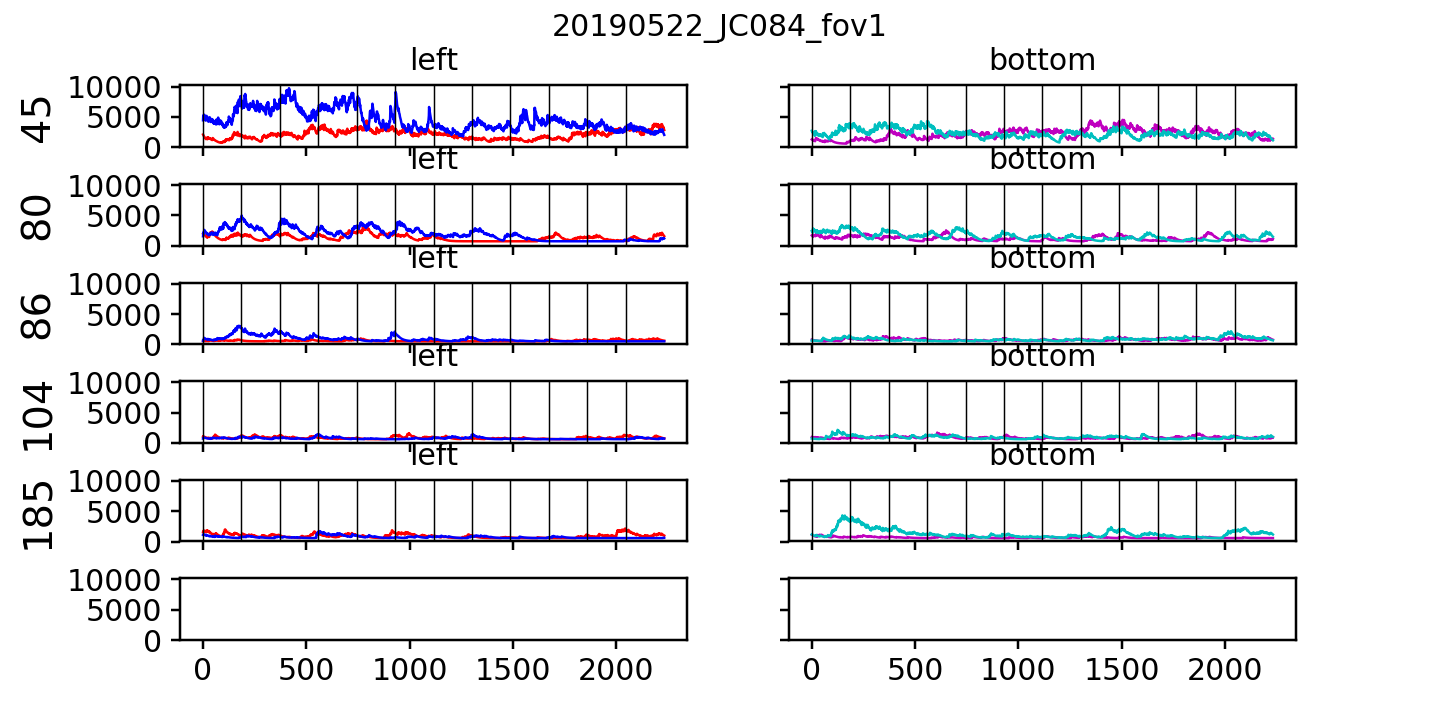

In [279]:
fig, axn = pl.subplots(len(funky_cm_rois)+1, 2, sharex=True, sharey=True, figsize=(8,len(funky)*2))
retino_conds = soma_traces.keys()

for ai, rid in enumerate(funky_cm_rois):
    for cond in retino_conds:
        if cond in ['left', 'right']:
            ac=0
        else:
            ac=1
        #ac = conditions.index(cond)
        ax=axn[ai, ac]
        ax.set_title("%s" % (cond), loc='center')
        #ax.plot(soma_traces[cond][rid], label=cond, color='k', lw=0.5)
        
        ax.plot(caiman[cond][rid], #-smoothed_traces[cond][rid].mean(), 
                label=cond, color=colors[cond], lw=1)
        for c in stiminfo['cycle_start_ixs']:
            ax.axvline(x=c, linestyle='-', color='k', lw=0.5)
        
    axn[ai, 0].set_ylabel(rid, rotation=90)
fig.suptitle(datakey)
pl.subplots_adjust(hspace=0.6)